In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import torch
import os.path
sys.path.append('../')
import topovelo as tpv
import matplotlib.pyplot as plt
from scipy.io import mmread, mmwrite
from numpy import savetxt
%load_ext autoreload
%autoreload 2

# Test for hard bugs

In [ ]:
dataset = 'Pancreas'
root = '/scratch/blaauw_root/blaauw1/gyichen'
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')

In [ ]:

model_path_base = f'{root}/checkpoints/{dataset}'
figure_path_base = f'{root}/figures/{dataset}'
data_path = f'{root}/data/velovae/continuous/{dataset}'
gene_plot = tpv.sample_genes(adata, 4, 'means')

In [ ]:
figure_path = f'{figure_path_base}/Graph'
model_path = f'{model_path_base}/Graph'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              attention=False)

In [ ]:
graph = adata.obsp['connectivities']

In [ ]:
config = {
    'n_epochs': 1,
    'n_epochs_post': 1
}
vae.train(adata, graph, config=config, plot=True, gene_plot=gene_plot, figure_path=figure_path)
#vae.save_model(model_path, 'encoder', 'decoder')
#vae.save_anndata(adata, 'velovae', data_path, file_name=f'{dataset}.h5ad')

In [ ]:
vae.graph_data.data.edge_index

In [ ]:
param_size = 0
for param in vae.encoder.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in vae.encoder.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
param_size = 0
for param in vae.decoder.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in vae.decoder.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
vae.save_anndata(adata, 'velovae', data_path, file_name=None)

In [ ]:
cluster_edges = [('Ngn3 low EP', 'Ngn3 high EP'),
                 ('Ngn3 high EP', 'Pre-endocrine'),
                 ('Pre-endocrine', 'Delta'),
                 ('Pre-endocrine', 'Beta'),
                 ('Pre-endocrine', 'Epsilon'),
                 ('Pre-endocrine', 'Alpha')]
res, res_type = tpv.post_analysis(adata,
                                 dataset,
                                 ['VeloVAE'],
                                 ['velovae'],
                                 compute_metrics=True,
                                 genes=gene_plot,
                                 grid_size=(1,4),
                                 figure_path=figure_path,
                                 cluster_edges=cluster_edges)

# Test Functionality 1

In [2]:
root = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/slide-seq/adult_cortex'
dataset = 'slide-seq-adult-cortex'
data_path_base = f'/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/{dataset}'
figure_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}'
model_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/checkpoints/{dataset}'

In [3]:
adata = anndata.read_h5ad(f'{root}/{dataset}_pp_hg.h5ad')

In [4]:
graph = mmread(f'{root}/DT_nn_graph.mtx').tocsr().T

In [8]:
figure_path = f'{figure_path_base}/tpv_2'
model_path = f'{model_path_base}/tpv_2'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              hidden_size=(30, 15, 15, 30),
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              xavier_gain=0.05)
adata.var['median_s'] = np.median(adata.layers['Ms'], 0)
adata.var['median_u'] = np.median(adata.layers['Mu'], 0)
gene_plot = tpv.sample_genes(adata, 4, 'median_s')
config = {
    #'early_stop_thred': 1.0,
    'train_edge_weight': True,
    #'save_epoch': 50,
}
vae.train(adata, graph, config=config, plot=False, gene_plot=gene_plot, figure_path=figure_path, embed='pos')

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Detected 49 velocity genes.
Estimating the variance...


  0%|          | 0/200 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.26408275486921723), (0.55, 0.6698011605402466)
(0.65, 0.7299912669575762), (0.35, 0.2378954727603067)
KS-test result: [0. 2. 0.]
Initial induction: 95, repression: 105/200
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/200 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0004
--------------------------- Train a VeloVAE ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 552.       *********
Summary: 
Train ELBO = 323.850
Test ELBO = 327.625
Total Time =   0 h :  2 m :  4 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/2525 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 51
*********       Round 1: Early Stop Triggered at epoch 584.       *********
Summary: 
Train ELBO = 507.468
Test ELBO = 500.893
Total Time =   0 h :  2 m : 12 s

Change in noise variance: 0.2030
*********             Velocity Refinement Round 2              *********
*********       Round 2: Early Stop Triggered at epoch 601.       *********
Summary: 
Train ELBO = 503.071
Test ELBO = 499.795
Total Time =   0 h :  2 m : 15 s

Change in noise variance: 0.0001
Change in x0: 0.2379
*********             Velocity Refinement Round 3              *********
*********       Round 3: Early Stop Triggered at epoch 609.       *********
Summary: 
Train ELBO = 489.885
Test ELBO = 496.118
Total Time =   0 h :  2 m : 17 s

Change in noise variance: 0.0000
Change in x0: 0.1923
*********             Velocity Refinement Round 4              *********
*********       Round 4: Early Stop Triggered at epoch 628.       *********
Summary: 
Train ELBO = 481

In [26]:
row, col, val = vae.get_enc_att(vae.graph_data.data.x, vae.graph_data.data.adj_t)

In [102]:
row, col, val = vae.get_dec_att(torch.tensor(adata.obsm['tpv_z']).to(vae.device), vae.graph_data.data.adj_t)

In [28]:
cell_labels = adata.obs['clusters'].to_numpy()

L5/6
['L5/6' 'L5/6' 'L5/6' 'L5/6' 'L5/6' 'CP' 'L5/6' 'L5/6']
[0.11674947 0.13087635 0.12156798 0.12458812 0.12421175 0.1281136
 0.12685157 0.12704118]


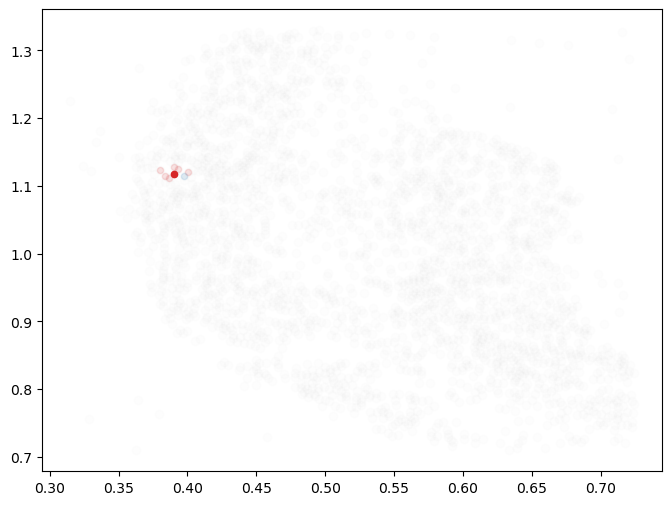

In [35]:
idx = 1772
neighbors = col[row[idx]:row[idx+1]]
print(cell_labels[idx])
print(cell_labels[neighbors])
scores = val[row[idx]:row[idx+1]].mean(1)
print(scores)
P = adata.obsm['X_pos']
colors = tpv.get_colors(8)
plt.figure(figsize=(8, 6))
plt.scatter(P[:, 0], P[:, 1], color='gray', alpha=0.01)
plt.scatter(P[idx:idx+1, 0], P[idx:idx+1, 1], s=20, color=colors[vae.cell_labels[idx]], edgecolors=None)
for i, nb in enumerate(neighbors):
    plt.scatter(P[nb:nb+1, 0], P[nb:nb+1, 1], s=20, color=colors[vae.cell_labels[nb]], edgecolors=None, alpha=scores[i])
plt.show()

In [9]:
vae.save_anndata(adata, 'tpv', data_path_base, file_name=None)

---   Plotting  Results   ---


(None, None)

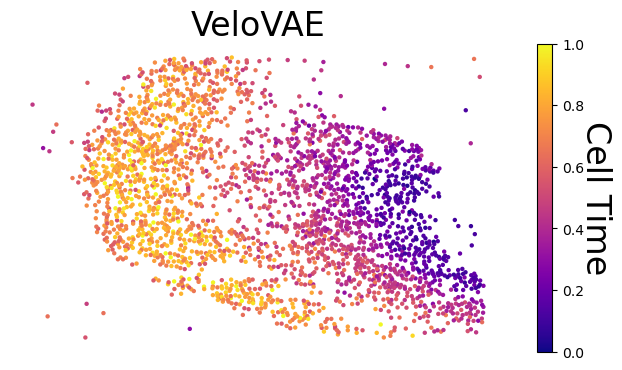

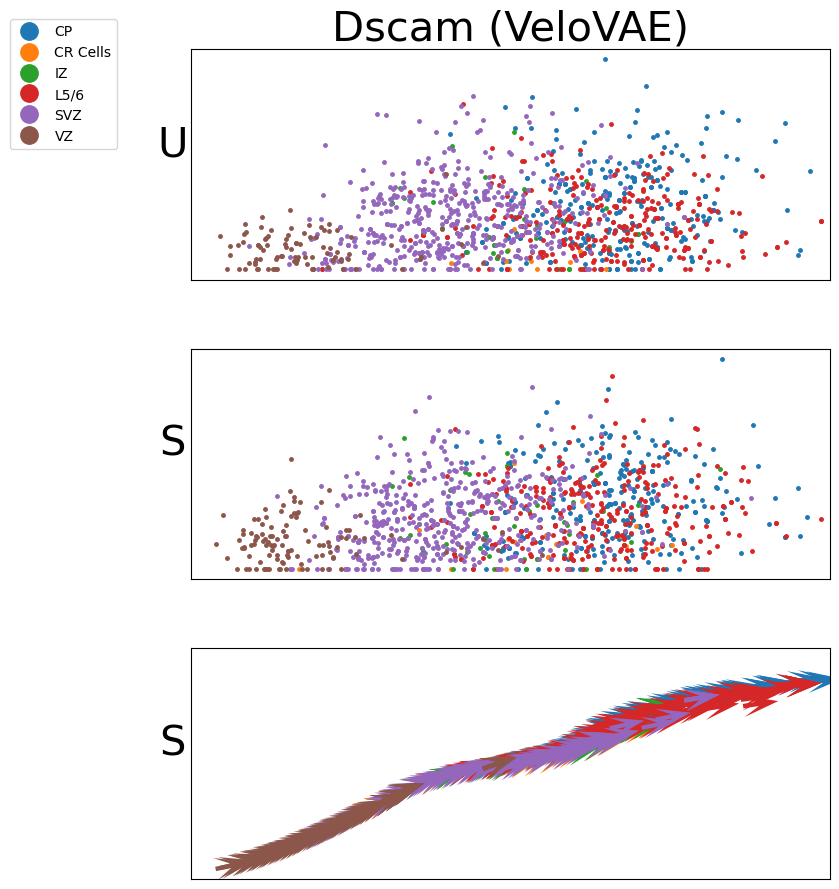

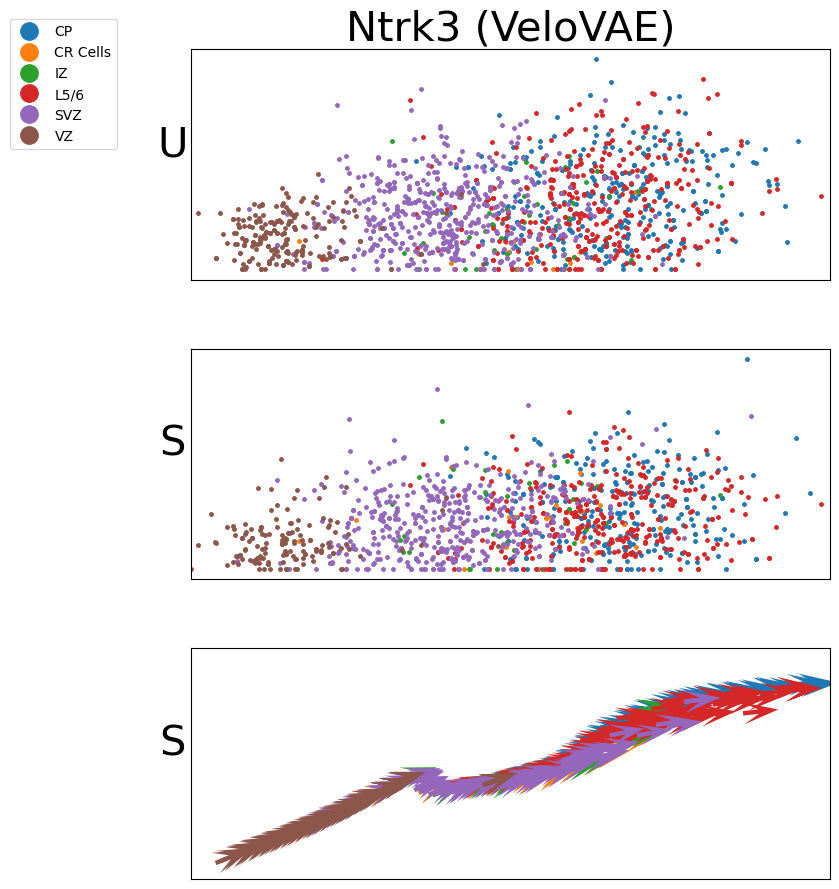

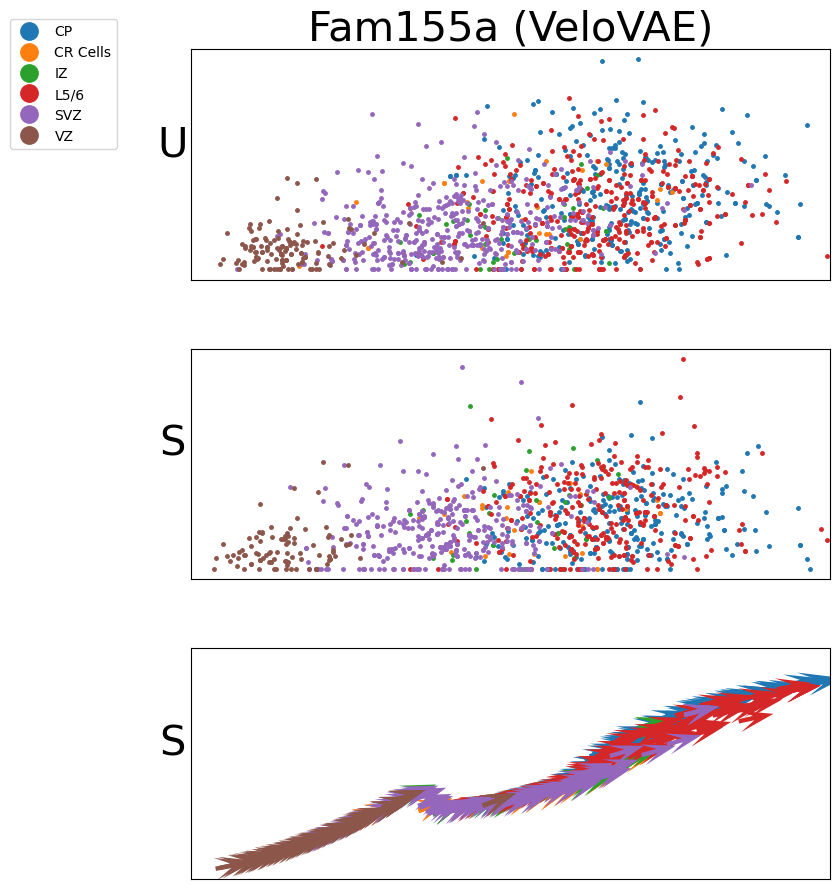

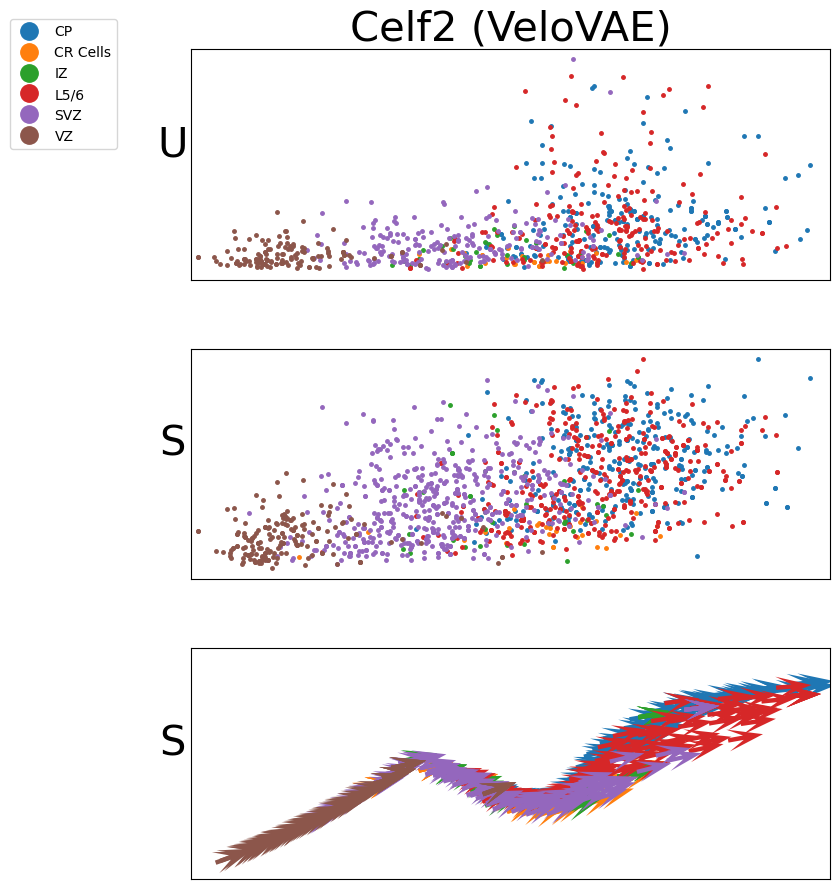

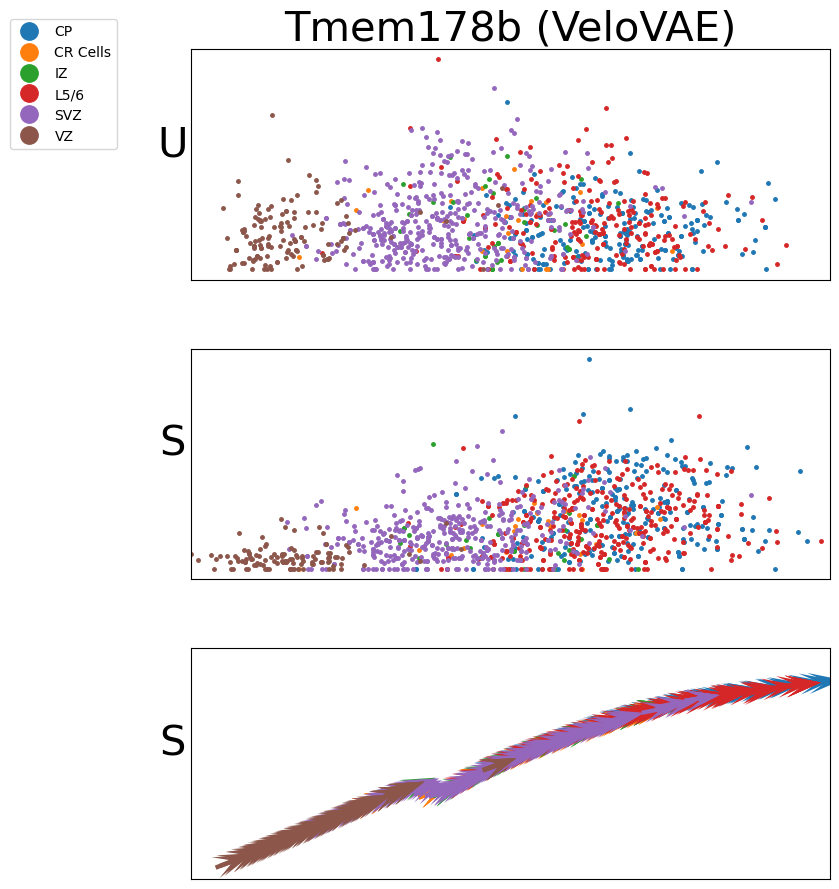

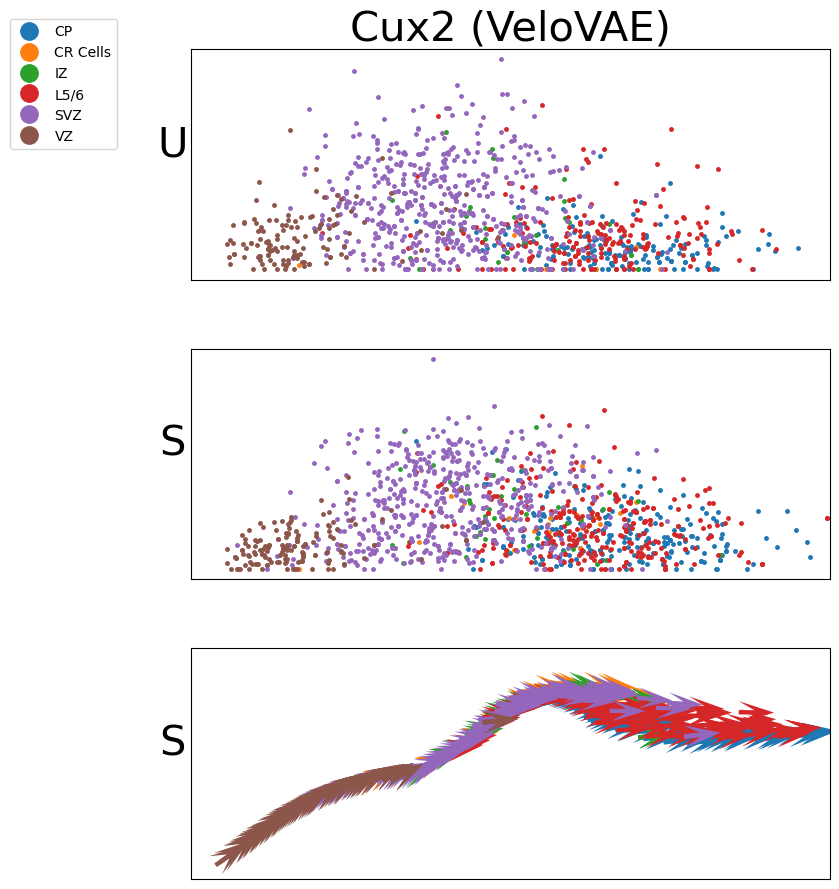

In [13]:
tpv.post_analysis(adata,
                  'graph_dec',
                  ['VeloVAE'],
                  ['tpv'],
                  compute_metrics=False,
                  #genes=["Map1b"],
                  genes=np.random.choice(adata.var_names, 6),
                  embed='pos',
                  plot_type=['time', 'gene'],
                  figure_path=figure_path)

computing velocity graph (using 1/40 cores)


  0%|          | 0/2525 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_pos', embedded velocity vectors (adata.obsm)


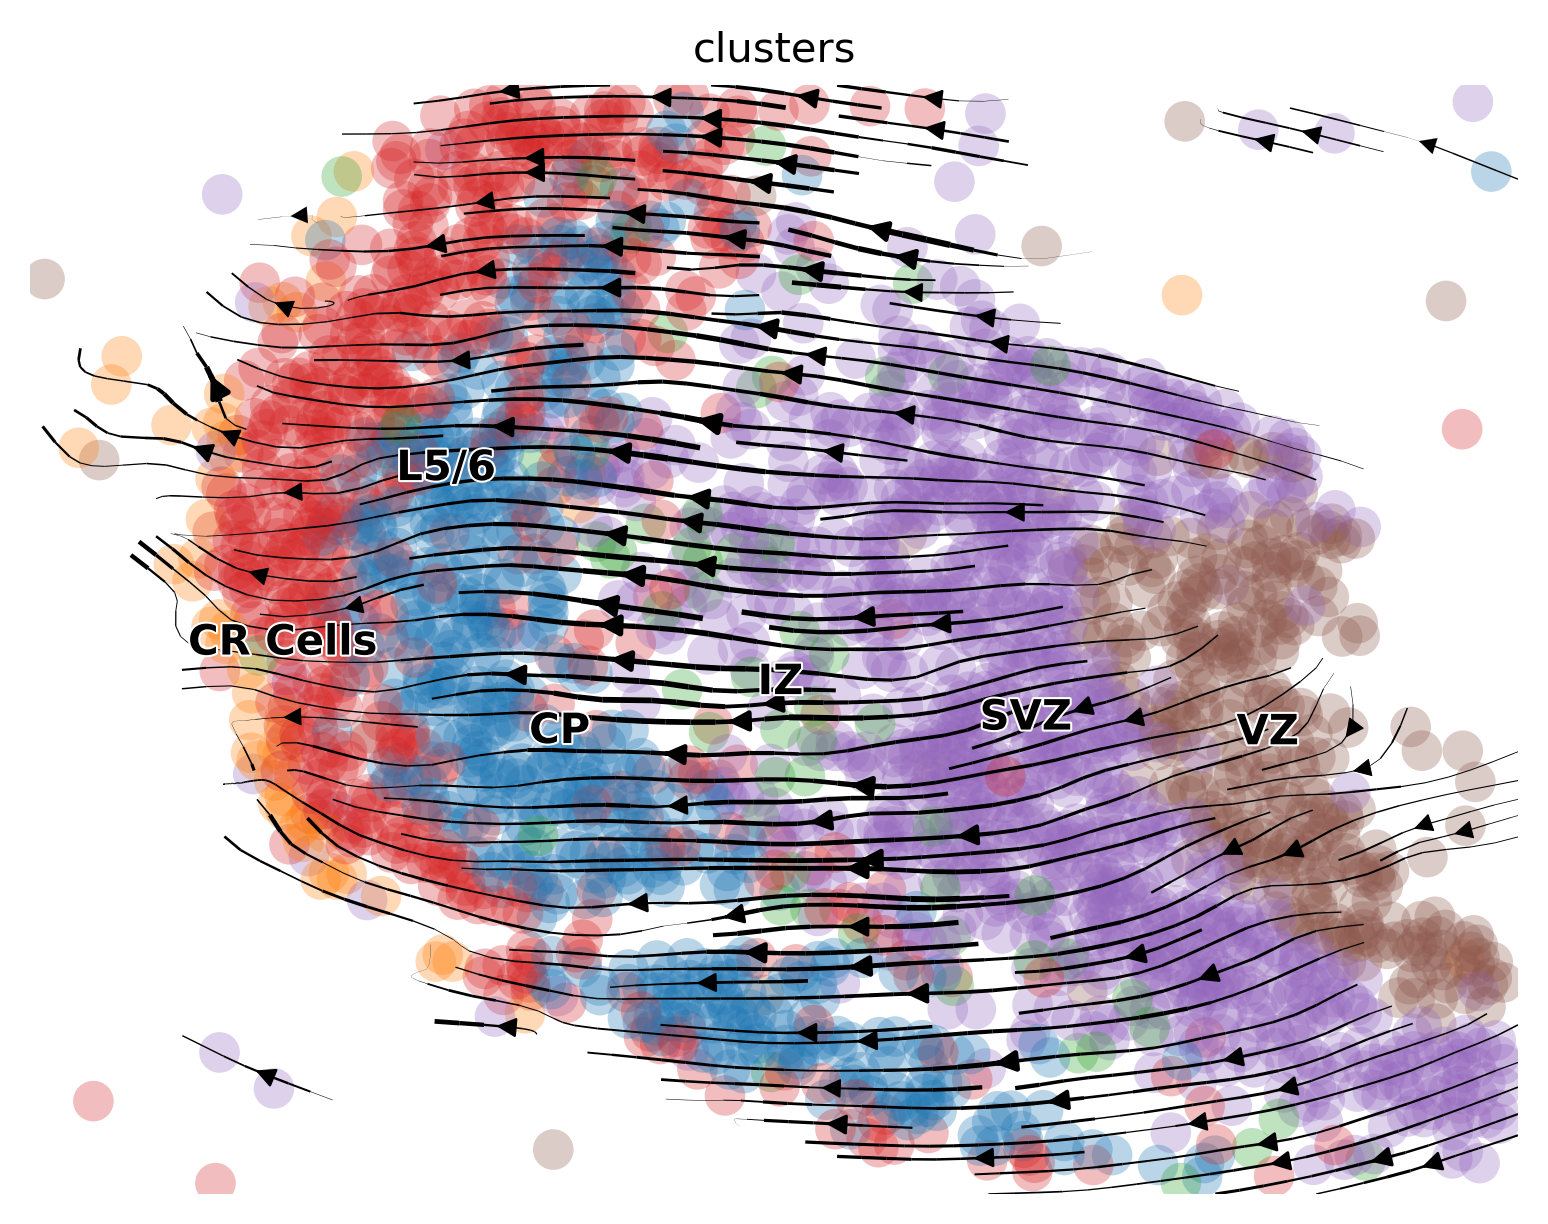

In [11]:
scv.tl.velocity_graph(adata, vkey='tpv_velocity')
scv.tl.velocity_embedding(adata, vkey='tpv_velocity', basis='pos')
scv.pl.velocity_embedding_stream(adata, vkey='tpv_velocity', basis='pos', dpi=300)

# Test Functionality 2

In [43]:
anndata_path = '/gpfs/accounts/welchjd_root/welchjd0/shared_data/StereoSeq_currentDir_051023/Stomics_h5ad'
rna_path = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/stereo_seq/binned_intron_exon/stereo_seq_binned'
scratch_path = f"/scratch/welchjd_root/welchjd/shared_data/gyichen"
figure_path_base = f"{scratch_path}/figures/stereo-seq-gut-e13.5"
model_path_base = f"{scratch_path}/figures/stereo-seq-gut-e13.5"

In [44]:
dataset = 'stereo-seq-gut-e13.5'
data_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq_gut_e13.5'
rna_path = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/stereo_seq/binned_intron_exon/stereo_seq_binned'
adata = anndata.read_h5ad(f'{rna_path}/E13.5/integrated/E13.5_gut.h5ad')
#adata = anndata.read_h5ad(f'{data_path_base}/adata_out.h5ad')

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 7 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.56, 0.7075575233670713), (0.44, 0.24127304066365884)
(0.51, 0.7058437676760514), (0.49, 0.2170714845088359)
(0.47, 0.21918407163157463), (0.53, 0.7067842676044147)
KS-test result: [0. 0. 0.]
Initial induction: 1046, repression: 954/2000
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Epoch 1: Train ELBO = -460.452,	Test ELBO = -36469.803,	Total Time =   0 h :  0 m :  3 s
Epoch 100: Train ELBO = 3024.009,	Test ELBO = 2983.643,	Total Time =   0 h :  0 m : 57 s
Epoch 200: Train ELBO = 2901.894,	Test ELBO = 3034.864,	Total Time =   0 h :  1 m : 52 s
Epoch 300: Train ELBO = 3037.453,	Test ELBO = 2790.019,	Total Time =   0 h :  2 m : 43 s
Epoch 400: Train ELBO = 3078.683,	Test ELBO = 3102.065,	Total Time =   0 h :  3 m : 30 s
Epoch 

  0%|          | 0/2381 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.036
Average Set Size: 50
Epoch 697: Train ELBO = 5186.480,	Test ELBO = 5169.448,	Total Time =   0 h :  5 m : 52 s
Epoch 700: Train ELBO = 5197.222,	Test ELBO = 5181.286,	Total Time =   0 h :  5 m : 55 s
*********       Round 1: Early Stop Triggered at epoch 714.       *********
Summary: 
Train ELBO = 5167.150
Test ELBO = 5195.758
Total Time =   0 h :  6 m :  1 s

Change in noise variance: 0.2953
*********             Velocity Refinement Round 2              *********
Epoch 715: Train ELBO = 5211.729,	Test ELBO = 5195.098,	Total Time =   0 h :  6 m :  4 s
*********       Round 2: Early Stop Triggered at epoch 722.       *********
Summary: 
Train ELBO = 5179.114
Test ELBO = 5198.625
Total Time =   0 h :  6 m :  7 s

Change in noise variance: 0.0000
Change in x0: 0.4787
*********             Velocity Refinement Round 3              *********
Epoch 723: Train ELBO = 5207.999,	Test ELBO = 5191.766,	Total Time =   0 h :  6 m : 10 s
*********       Round 3: Early

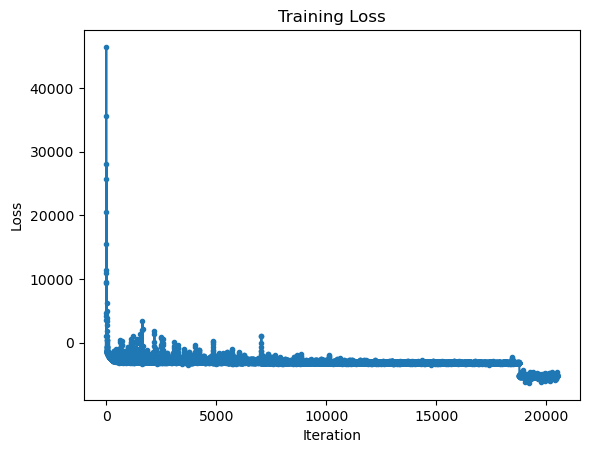

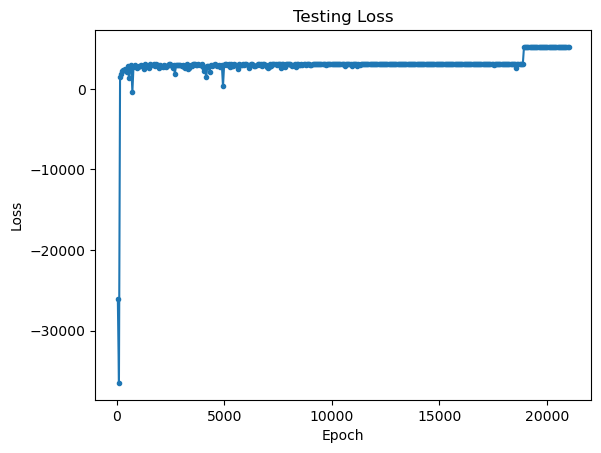

In [46]:
figure_path = f'{figure_path_base}/tpv_2'
model_path = f'{model_path_base}/tpv_2'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=False,
              xavier_gain=0.05)
config = {
    'batch_size':64
}
genes = ['Foxp2', 'Gnas', 'Npm1']
test_samples = np.random.choice(adata.n_obs, int(adata.n_obs*0.1), replace=False)
vae.train(adata,
          adata.obsp['spatial_graph'],
          config=config,
          plot=True,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial',
          test_samples=test_samples)
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata,
                 'tpv',
                 data_path_base,
                 file_name=None)

---   Plotting  Results   ---


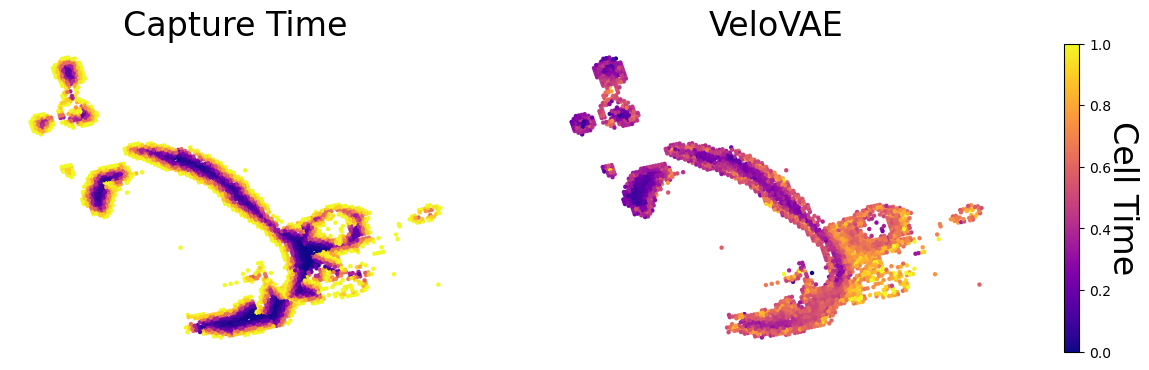

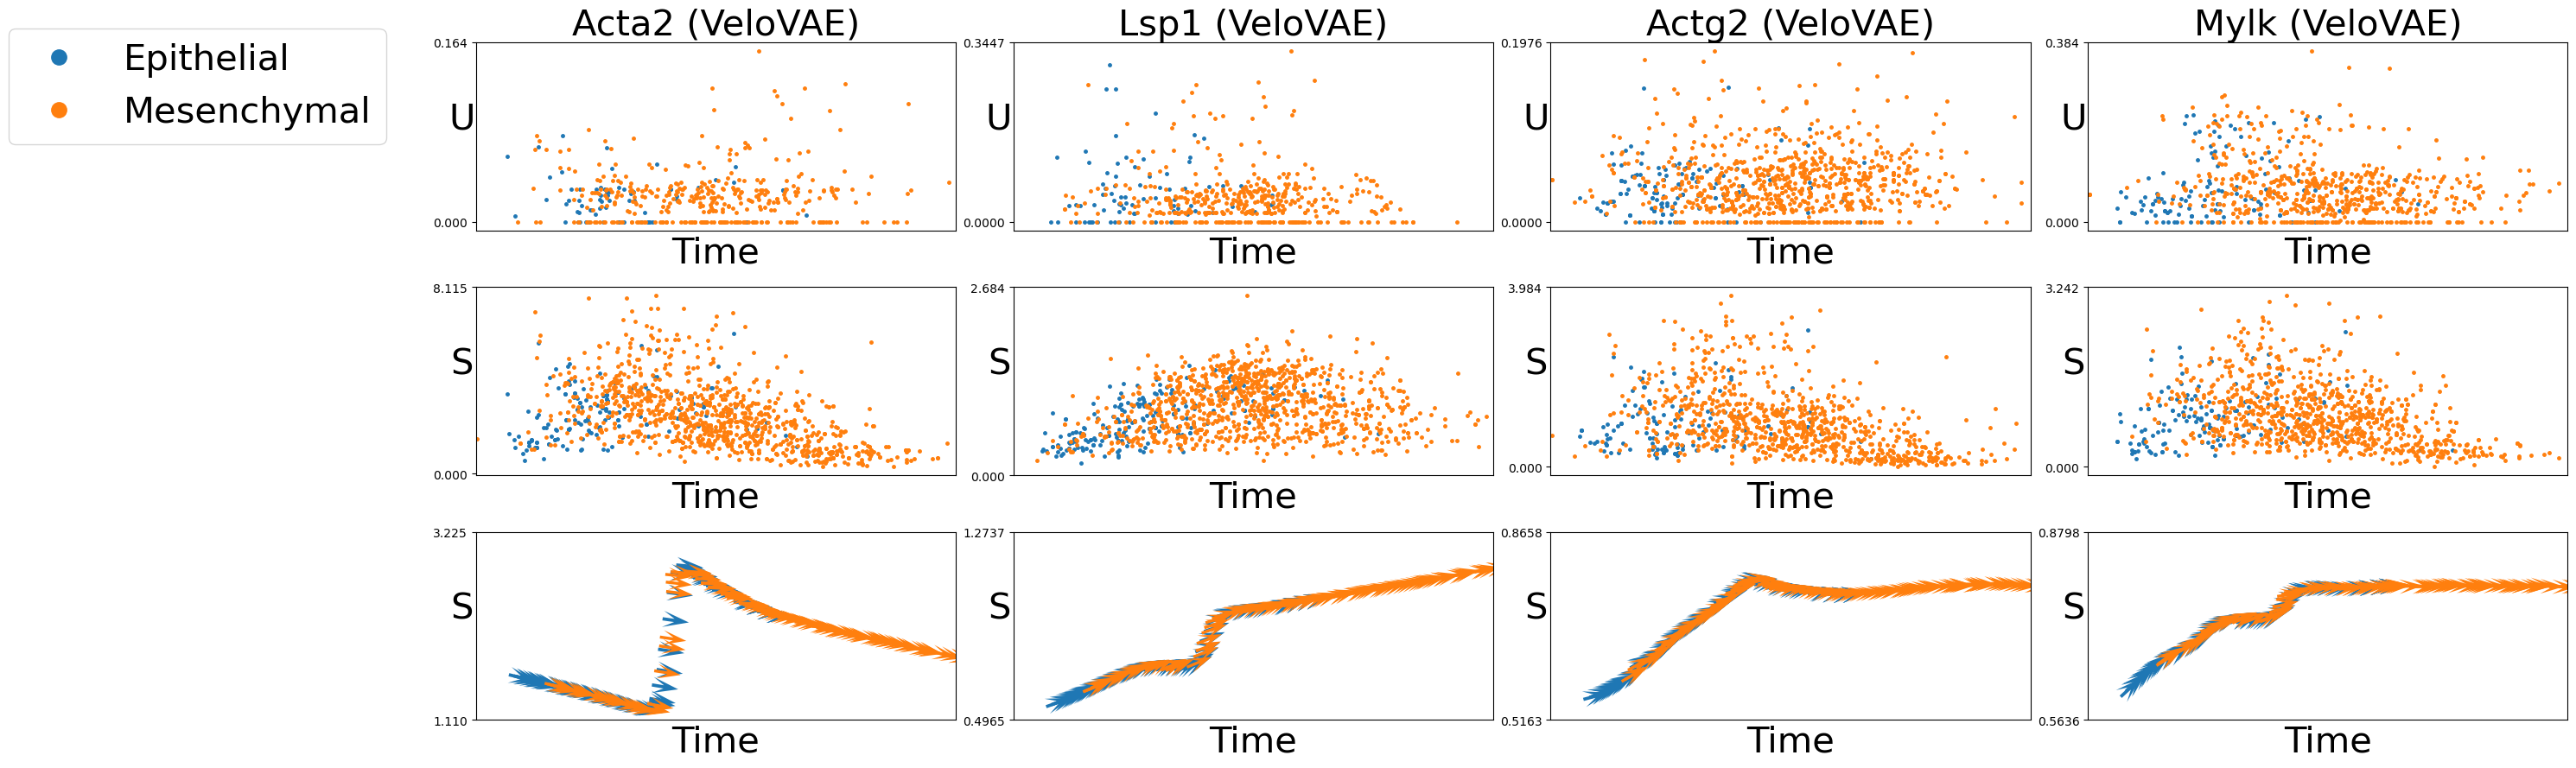

In [47]:
tpv.plotting.set_dpi(200)
genes = ["Acta2", "Lsp1", "Actg2", "Myl9", "Mylk"]
res, res_type = tpv.post_analysis(adata,
                                  'gut',
                                  ['VeloVAE'],
                                  ['tpv'],
                                  compute_metrics=False,
                                  genes=genes,
                                  grid_size=(1, 4),
                                  embed='spatial',
                                  plot_type=['gene', 'time'],
                                  figure_path=figure_path_base)

In [48]:
from sklearn.neighbors import NearestNeighbors
X_pos = adata.obsm['X_spatial']
nn = NearestNeighbors(n_neighbors=30)
nn.fit(X_pos)
adata.obsp['connectivities'] = nn.kneighbors_graph(mode='connectivity')
adata.obsp['distances'] = nn.kneighbors_graph(mode='distance')

In [49]:
scv.tl.velocity_graph(adata, vkey='tpv_velocity')
scv.tl.velocity_embedding(adata, vkey='tpv_velocity', basis='spatial')

computing velocity graph (using 1/40 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)


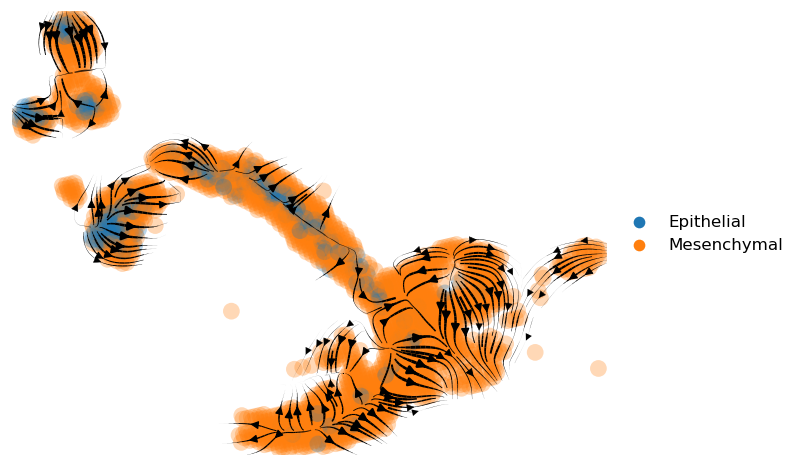

In [50]:
#scv.tl.velocity_graph(adata, vkey='tpv_velocity')
scv.pl.velocity_embedding_stream(adata, title="", vkey='tpv_velocity', legend_loc="right margin", density=4.0, cutoff_perc=0, dpi=120,
                                 basis='spatial')

# Batch Correction

In [36]:
anndata_path = '/gpfs/accounts/welchjd_root/welchjd0/shared_data/StereoSeq_currentDir_051023/Stomics_h5ad'
rna_path = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/stereo_seq/binned_intron_exon/stereo_seq_binned'
figure_path_base = f"/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-forebrain-e10.5-13.5"
model_path_base = f"/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-forebrain-e10.5-13.5"
adata = anndata.read_h5ad('/nfs/turbo/umms-welchjd/yichen/data/scRNA/CytoSignal_Jialin/output/stereo_seq_brain_e10.5_e13.5/forebrain_pp.h5ad')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/nfs/turbo/umms-welchjd/yichen/data/scRNA/CytoSignal_Jialin/output/stereo_seq_brain_e10.5_e13.5/forebrain_pp.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Memory Consumption

In [ ]:
root = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/slide-seq/adult_cortex'
dataset = 'slide-seq-adult-cortex'
data_path_base = f'/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/{dataset}'
figure_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/figures/{dataset}'
model_path_base = f'/scratch/welchjd_root/welchjd/shared_data/gyichen/checkpoints/{dataset}'

In [ ]:
adata = anndata.read_h5ad(f'{root}/{dataset}_pp_hg.h5ad')

In [ ]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 25, 50),
              device='cuda:0',
              attention=False)
graph = mmread(f'{root}/DT_nn_graph.mtx').tocsr().T
config = {
    'early_stop_thred': 1.0
}
vae.train(adata, graph, config=config, plot=False, figure_path=figure_path, embed='pos')

In [ ]:
vae.save_anndata(adata, 'tpv', data_path_base, file_name=None)

In [ ]:
scv.tl.velocity_graph(adata, vkey='tpv_velocity')
scv.pl.velocity_embedding_stream(adata, vkey='tpv_velocity', basis='pos')

In [ ]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'

torch.manual_seed(2022)
np.random.seed(2022)

vae2 = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              hidden_size=(50, 25, 25, 50),
              device='cuda:0',
              attention=False)
config = {
    'n_epochs': 1,
    'n_epochs_post': 0
}
vae2.train(adata, graph, config=config, plot=False, figure_path=figure_path, embed='pos')

In [ ]:
vae2.graph_data.data.edge_index

In [ ]:
from torch_sparse import SparseTensor
edge_index=vae2.graph_data.data.edge_index
edge_attr=vae2.graph_data.edge_weight
adj = SparseTensor(row=edge_index[0], col=edge_index[1], value=edge_attr)

In [ ]:
vae2.graph_data.data.x.nelement()*vae2.graph_data.data.x.element_size() / (1024**2)

In [ ]:
edge_index.nelement()*edge_index.element_size() / (1024**2)

In [ ]:
edge_attr.nelement()*edge_attr.element_size() / (1024**2)

# Visualization of Tissue Growth
## 1. Fit cell number growth rate

In [2]:
root = "/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq_brain_e10.5_e13.5"

In [3]:
adata = anndata.read_h5ad(f"{root}/adata_out.h5ad")

In [279]:
batch = adata.obs['batch'].to_numpy()
v_emb = np.zeros((adata.n_obs, 2))
for b in ['0', '1', '2', '3']:
    cell_mask = batch == b
    adata_sub = adata[cell_mask]
    scv.pp.neighbors(adata_sub)
    tpv.analysis.use_spatial_knn(adata_sub, "X_spatial")
    n_jobs = 1 if adata_sub.n_obs < 5000 else adata_sub.n_obs//500
    scv.tl.velocity_graph(adata_sub, vkey="tpv_velocity", n_jobs=n_jobs)
    scv.tl.velocity_embedding(adata_sub, vkey="tpv_velocity", basis="spatial")
    v_emb[cell_mask] = adata_sub.obsm['tpv_velocity_spatial']

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/36 cores)


  0%|          | 0/131 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/36 cores)


  0%|          | 0/632 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/36 cores)


  0%|          | 0/1033 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/36 cores)


  0%|          | 0/1899 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)


In [238]:
#df = pd.read_csv('/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/stereo_seq/binned_intron_exon/stereo_seq_binned/num_cell.csv',
#                 index_col=0)
time_points = np.array(df.index)
num_cells = df["all"].to_numpy()
k = tpv.analysis._fit_growth_rate(num_cells, time_points)

In [239]:
from scipy.optimize import minimize, LinearConstraint
def f_exp(x, t, n):
    return n[0]*np.exp(-x*(t-t[0]))+n[-1]*(1-np.exp(-x*(t-t[0])))
def f_logis(x, t, n):
    return n[-1]/(1 + np.exp(-x[0]*t-x[1]))
def l2_loss(x, t, n):
    return np.mean((f_logis(x, t, n) - n)**2)
#ub = (np.log(num_cells[-1])-np.log(num_cells[-1]+num_cells[0]))/time_points[0]
#print(ub)
#constraint = LinearConstraint(np.ones((1,1)),
#                              ub=np.array([ub]))
out = minimize(l2_loss, np.array([0, 0]), args=(time_points, num_cells))#, method="COBYLA", constraints=constraint)

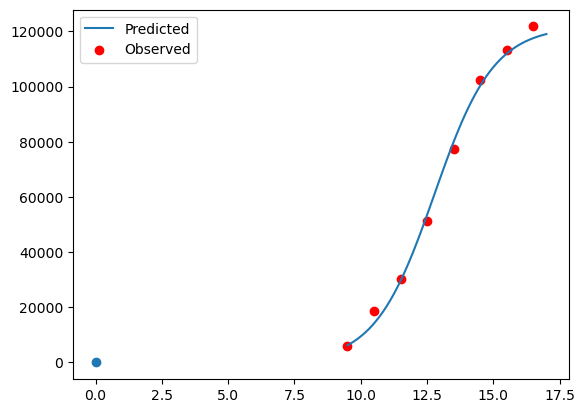

In [240]:
t_eval = np.linspace(9.5, 17, 101)
n_pred = f_logis(out.x, t_eval, num_cells)
plt.figure()
plt.plot(t_eval, n_pred, label="Predicted")
plt.scatter(time_points, num_cells, color="r", label="Observed")
plt.scatter([0], [0])
plt.legend()
plt.show()

In [280]:
boundary = tpv.analysis._find_boundary_points(adata_sub, 'X_spatial', 0.95)

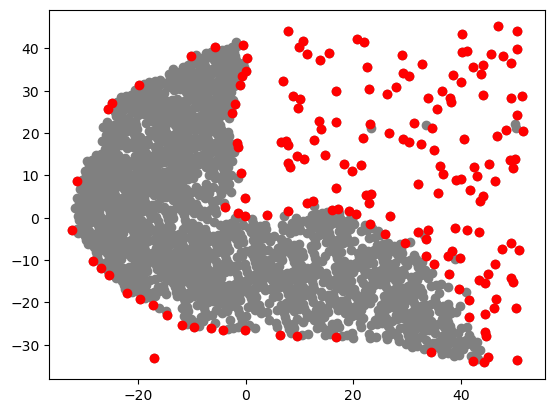

In [281]:
X = adata_sub.obsm["X_spatial"]
plt.figure()
plt.scatter(X[:, 0], X[:, 1], color='grey', edgecolor=None)
plt.scatter(X[boundary, 0], X[boundary, 1], color='red')

In [282]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=25)
nn.fit(X)
dist, ind = nn.kneighbors(X[boundary])
dist_max = np.max(dist, 1)

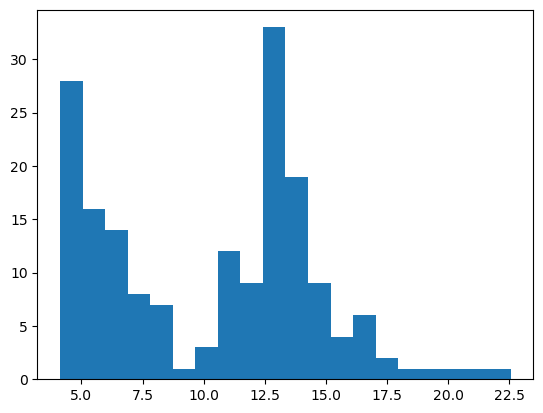

In [283]:
plt.figure()
plt.hist(dist_max, 20)
plt.show()

In [284]:
boundary = boundary[dist_max < 9]

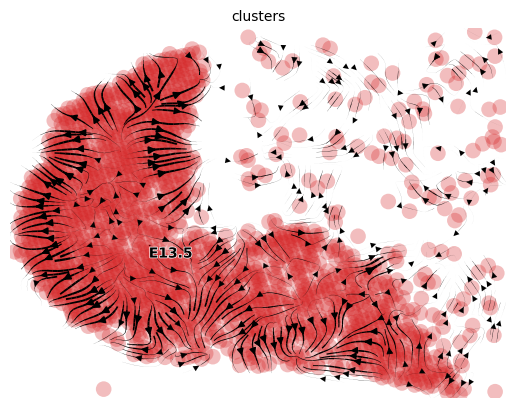

In [159]:
scv.pl.velocity_embedding_stream(adata_sub, vkey='tpv_velocity', basis='spatial', density=3.0, cutoff_perc=0)

In [142]:
arr = np.random.permutation(30)
print(arr)
tpv.analysis._find_max_3(arr)

[22 26  4 25  6 19 28  3 29 20  2 10 17 12 15 21 11  5 24  1 18 14  8  7
 23 13 16  9 27  0]


array([29, 28, 27])

In [231]:
area, ds = tpv.analysis._est_area(X, 100)

Get an ordering of boundary points by putting them in a counter-clockwise order

In [225]:
ps = tpv.analysis._nearest_boundary_point(boundary, X, adata_sub.obsm['tpv_velocity_spatial'], 3)

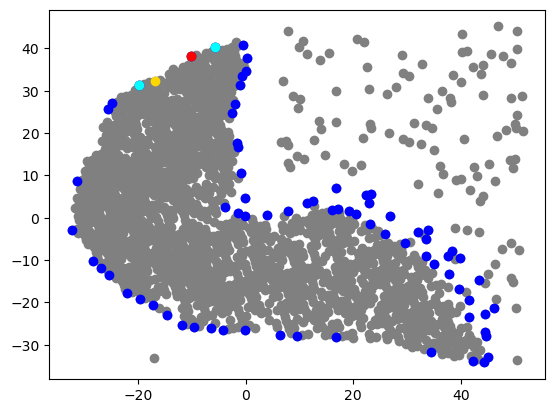

In [229]:
idx = np.random.choice(adata_sub.n_obs)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], color='grey', edgecolor=None)
plt.scatter(X[boundary, 0], X[boundary, 1], color='blue')
plt.scatter(X[idx:idx+1, 0], X[idx:idx+1, 1], color='gold')
plt.scatter(X[[ps[idx,0]], 0], X[[ps[idx,0]], 1], color='red')
plt.scatter(X[[ps[idx,1]], 0], X[[ps[idx,1]], 1], color='cyan')
plt.scatter(X[[ps[idx,2]], 0], X[[ps[idx,2]], 1], color='cyan')
plt.show()

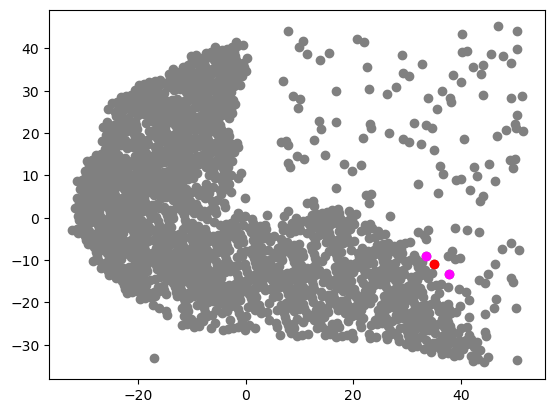

In [219]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], color='grey', edgecolor=None)
idx = np.random.choice(len(boundary))
plt.scatter(X[[boundary[(idx-1)%len(boundary)]], 0], X[[boundary[(idx-1)%len(boundary)]], 1], color='magenta')
plt.scatter(X[[boundary[idx]], 0], X[[boundary[idx]], 1], color='red')
plt.scatter(X[[boundary[(idx+1)%len(boundary)]], 0], X[[boundary[(idx+1)%len(boundary)]], 1], color='magenta')
plt.show()

In [359]:
weight = tpv.analysis._dist_weight(adata_sub.obsm['tpv_velocity_spatial'])

In [241]:
num_cells

array([  5913,  18670,  30124,  51216,  77368, 102519, 113350, 121763])

In [286]:
num_cells_pred = f_logis(out.x, 14.5, num_cells) * (adata_sub.n_obs / num_cells[4])
print(num_cells_pred)

2460.419099143836


In [360]:
# Simulate tissue growth
total_growth = (num_cells_pred - adata_sub.n_obs)/adata_sub.n_obs*area
delta_xy = X[ps[:, 0]] - X
delta_xy = delta_xy / (np.linalg.norm(delta_xy, 1).reshape(-1, 1))
assert ~np.any(np.isnan(delta_xy))
print(total_growth)

373.2757286321345


In [363]:
delta_xy.shape

(1899, 2)

In [365]:
np.linalg.norm(delta_xy, 1)

1.000000000000002

In [352]:
delta_a = total_growth * weight
delta_a_unit = np.abs(np.sum((X[ps[:, 1]] - X[ps[:, 0]])*delta_xy, 1))
delta_a_unit += np.abs(np.sum((X[ps[:, 2]] - X[ps[:, 0]])*delta_xy, 1))
scale = np.clip(np.sqrt(delta_a/delta_a_unit), 0, 1e4)

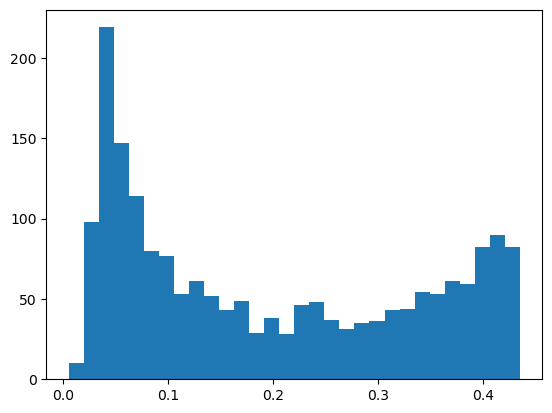

In [340]:
plt.figure()
plt.hist(delta_a, 30)
plt.show()

In [342]:
scale.max()

10000.0

In [351]:
scale = np.sqrt(weight)
delta_xy = delta_xy * scale.reshape(-1, 1) * 100

In [353]:
X_new_boundary = np.zeros(X.shape)
for idx in boundary:
    mask = ps[:, 0] == idx
    X_new_boundary[idx] = X[idx] + np.sum(delta_xy[mask], 0)
    print(np.sum(delta_xy[mask], 0))
X_new_boundary = X_new_boundary[boundary]

[-0.03279614 -0.01819777]
[-0.01454804 -0.0045882 ]
[-0.04266768 -0.01816665]
[-0.03848183 -0.02319719]
[-0.00878936 -0.01570901]
[-0.01573508 -0.01578937]
[-0.02402411 -0.02187925]
[-0.01010337 -0.01908165]
[-0.01133613 -0.02672292]
[-0.00472529 -0.02187421]
[-0.00246322 -0.02268853]
[ 0.000531  -0.0446842]
[-0.00384423 -0.02213868]
[ 0.01102961 -0.03558478]
[ 0.02578859 -0.06630407]
[ 0.06265973 -0.06187039]
[ 0.04115542 -0.03058589]
[ 0.00862936 -0.0038965 ]
[ 0.03365152 -0.02175802]
[ 0.03463237 -0.01408599]
[ 0.00698064 -0.0033302 ]
[ 0.01215334 -0.00474661]
[ 0.01930411 -0.00778707]
[ 0.02132713 -0.02679958]
[ 0.00605954 -0.00415468]
[ 0.00521501 -0.00037276]
[ 0.00485944 -0.00231387]
[0.00832748 0.00061041]
[0.00405751 0.00241582]
[ 0.00331845 -0.00092083]
[0.00944779 0.00200785]
[0.00152981 0.00371101]
[ 0.01859832 -0.00154213]
[0.00991563 0.00836955]
[ 0.00979721 -0.00156675]
[0.00280865 0.00751862]
[0.01362385 0.00748056]
[0.01324857 0.00695974]
[0.00913335 0.00694342]
[0.007

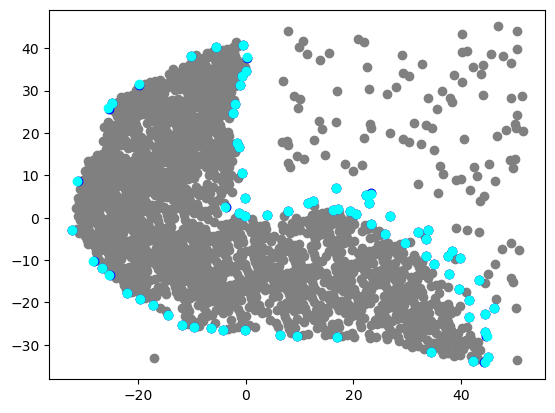

In [354]:
idx = np.random.choice(adata_sub.n_obs)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], color='grey', edgecolor=None)
plt.scatter(X[boundary, 0], X[boundary, 1], color='blue')
plt.scatter(X_new_boundary[:, 0], X_new_boundary[:, 1], color='cyan')
plt.show()

In [265]:
np.max(X_new_boundary - X[boundary])

0.0